In [1]:
%matplotlib inline
#%matplotlib qt
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import numpy as np
import numpy
from scipy.stats import gaussian_kde
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import maxflow
kwargs = {'bins' : 100, 'alpha' : 0.8, 'normed' : True}
BRICK_X = 124000
# Changed due to ignorance of 57th layer. Originally : #BRICK_Y = 99000
BRICK_Y = 76710
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205

import numpy.linalg as la
 
def angle(v1, v2):
    cos = (v1*v2).sum(axis=1)
    sin = la.norm(numpy.cross(v1, v2, axis=1), axis=1)
    return numpy.arctan2(sin, cos)

Welcome to JupyROOT 6.11/01


In [2]:
def load_bg(step=1000):
    # ignore 57th layer since it looks different
    etalon_plates = []
    for p in range(48, 57):
        backtracks = root_numpy.root2array("129294.{p}.1.1000.cp.root".format(p=p), 
                                       treename="couples", 
                                       branches=["s.eX", "s.eY", "s.eZ",
                                                "s.eTX", "s.eTY",
                                                "s.eChi2"], step=step)
        etalon_plates.append(backtracks)
    df = None
    for p in range(58):
        plate = numpy.copy(etalon_plates[p % len(etalon_plates)])
        plate['s.eZ'] = p * 1293
        # plt.hist(backtracks['s.eY'], bins=100, histtype='step', label="%d"%p)
        if df is None:
            df = pd.DataFrame(plate)
            # print ">", df.shape
        else:
            df = pd.concat([df, pd.DataFrame(plate)], ignore_index=True)
    # plt.legend()
    print ("bg: {n} tracks".format(n=df.shape[0]))
    return df

def load_mc(filename="mcdata_taue2.root", step=1):
    mc = root_numpy.root2array(
                        filename,
                        treename="Data",
                        branches=["Event_id", "ele_P",
                                   "BT_X", "BT_Y", "BT_Z",
                                   "BT_SX", "BT_SY",
                                   "ele_x", "ele_y", "ele_z", 
                                   "ele_sx", "ele_sy", 
                                   "chisquare"],
                        step=step)
    pmc = pd.DataFrame(mc)
    pmc['numtracks'] = pmc.BT_X.apply(lambda x: len(x))
    # cuts
    shapechange = [pmc.shape[0]]
    pmc = pmc[pmc.ele_P > 0.1]
    shapechange.append(pmc.shape[0])
    
    pmc = pmc[pmc.ele_z < 0]
    shapechange.append(pmc.shape[0])
    
    pmc = pmc[pmc.numtracks > 3]
    shapechange.append(pmc.shape[0])
    print ("numtracks reduction by cuts: ", shapechange)
    # calc centers
    # to brick reference frame and center
    pmc['m_BT_X'] = pmc.BT_X.apply(lambda x: x.mean())
    pmc['m_BT_Y'] = pmc.BT_Y.apply(lambda x: x.mean())
    pmc['m_BT_Z'] = pmc.BT_Z.apply(lambda x: x.mean())

    print ("len(pmc): {len}".format(len=len(pmc)))
    return pmc

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

def metric_res(u, v):
    X = numpy.array([[u[0], u[0] + u[3]*dZ, v[0], v[0] + v[3]*dZ], 
                     [u[1], u[1] + u[4]*dZ, v[1], v[1] + v[4]*dZ],
                     [u[2], u[2] + dZ, v[2], v[2] + dZ]]).T
    pca = PCA(n_components=1).fit(X)
    t = ((X - pca.mean_)/pca.components_).mean(axis=1)
    res = (X - pca.mean_) - pca.components_*t[:,numpy.newaxis]
    residual = numpy.sqrt(((res**2).sum(axis=1)).sum())
    return residual

def metric_angle(u, v):
    alpha_1 = angle(numpy.array([[u[3], u[4], 1]]), 
                    numpy.array([[v[0] - u[0], v[1] - u[1], v[2] - u[2]]]))
    alpha_2 = angle(numpy.array([[u[3], u[4], 1]]), 
                    numpy.array([[v[0] + dZ*v[3] - u[0], v[1] + dZ*v[4] - u[1], v[2] + dZ - u[2]]]))
    alpha_3 = angle(numpy.array([[v[3], v[4], 1]]), 
                    numpy.array([[v[0] + dZ*v[3] - u[0], v[1] + dZ*v[4] - u[1], v[2] + dZ - u[2]]]))
    alpha_4 = angle(numpy.array([[v[3], v[4], 1]]), 
                    numpy.array([[v[0] + dZ*v[3] - u[0] - dZ*u[3], v[1] + dZ*v[4] - u[1] - dZ*u[4], v[2]  - u[2]]]))
    alpha_1 = min(alpha_1, numpy.pi - alpha_1)
    alpha_2 = min(alpha_2, numpy.pi - alpha_2)
    alpha_3 = min(alpha_3, numpy.pi - alpha_3)
    alpha_4 = min(alpha_4, numpy.pi - alpha_4)
    return alpha_1 + alpha_2 + alpha_3 + alpha_4

def plot_bg(df, step=1):
    dZ = 205
    # mind the order!
    d0 = pd.DataFrame([
                df['s.eZ'][::step],
                df['s.eX'][::step],
                df['s.eY'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['s.eTX'][::step]*dZ,
            df['s.eTY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=10)
    ax.add_collection3d(lc)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(d0['z'].min(), d0['z'].max())
    ax.set_ylim(d0['x'].min(), d0['x'].max())
    ax.set_zlim(d0['y'].min(), d0['y'].max())
    print ("len(slopes): {slopes}".format(slopes=numtracks))

In [4]:
import copy
BT_Z_unique = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])
BRICK_X_MIN = 27762
BRICK_X_MAX = 72240
BRICK_Y_MIN = 3312
BRICK_Y_MAX = 76710
SAFE_M = 5000
dZ = 205

#numpy-vectorized function for rounding Z-coordinate
def round_Z_coodr(x):
    return BT_Z_unique[np.argmin(np.abs(BT_Z_unique - x))]
round_Z_coodr = np.vectorize(round_Z_coodr)

def combine_mc_bg(pmc, pbg, events = [0], bg_frac=0.1):
    #first of all generate background with random permutation by Z-axis
    pbg_frac = copy.deepcopy(pbg.sample(frac=bg_frac))
    pbg_frac['s.eZ'] = numpy.random.choice(BT_Z_unique, size=len(pbg_frac))
    dmix = copy.deepcopy(pbg_frac[['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY']])
    dmix.columns = ['sx', 'sy', 'sz', 'TX', 'TY']
    dmix['ex'] = pbg_frac['s.eX'] + pbg_frac['s.eTX']*dZ
    dmix['ey'] = pbg_frac['s.eY'] + pbg_frac['s.eTY']*dZ
    dmix['ez'] = pbg_frac['s.eZ'] + dZ
    dmix['chi2'] = pbg_frac['s.eChi2']
    dmix['signal'] = 0
    dmix['ele_x'] = -999
    dmix['ele_y'] = -999
    dmix['ele_z'] = -999
    dmix['ele_sx'] = -999
    dmix['ele_sy'] = -999
    dmix['ele_sz'] = -999
    
    dd = dmix
    #now we are generating signal uniformly in brick
    for id in events:
        index = pmc.loc[pmc.Event_id == id].index[0]
        df = copy.deepcopy(pmc.loc[index])
        #find length of shower
        length = df['BT_Z'].max() - df['BT_Z'].min()
        
        #unifrom generation of shower start
        start_x = np.random.uniform(low=BRICK_X_MIN + SAFE_M, high=BRICK_X_MAX - SAFE_M)
        start_y = np.random.uniform(low=BRICK_Y_MIN + SAFE_M, high=BRICK_Y_MAX - SAFE_M)
        start_z = np.random.uniform(low=0., high=BT_Z_unique.max() - length)
        
        delta_x = start_x - df['ele_x']
        df['BT_X'] += delta_x
        df['ele_x'] += delta_x
        
        delta_y = start_y - df['ele_y']
        df['BT_Y'] += delta_y
        df['ele_y'] += delta_y
        
        delta_z = start_z - df['ele_z']
        df['BT_Z'] += delta_z
        df['ele_z'] += delta_z
        
        df['BT_Z'] = round_Z_coodr(df['BT_Z'])
        df['ele_z'] = round_Z_coodr(df['ele_z']).ravel()[0]
        
        dmc = pd.DataFrame([        
                    df['BT_X'],
                    df['BT_Y'],
                    df['BT_Z'],
                    df['BT_SX'],
                    df['BT_SY'],
                    df['BT_X'] + df['BT_SX']*dZ,
                    df['BT_Y'] + df['BT_SY']*dZ,
                    df['BT_Z'] + dZ,
                    df['chisquare'][:len(df['BT_X'])]],
                    index=['sx', 'sy', 'sz', 'TX', 'TY', 
                  'ex', 'ey', 'ez', 'chi2']).T
        dmc['signal'] = 1
        dmc['ele_x'] = df['ele_x']
        dmc['ele_y'] = df['ele_y']
        dmc['ele_z'] = df['ele_z']
        dmc['ele_sx'] = df['ele_sx']
        dmc['ele_sy'] = df['ele_sy']
        dmc['ele_sz'] = 1
        
        dd = pd.concat([dd, dmc])

        
    #alpha = angle(numpy.array([(dd['sx'] - dd['ele_x']), (dd['sy'] - dd['ele_y']), (dd['sz'] - dd['ele_z'])]).T, 
    #              numpy.array([dd['ele_sx'], dd['ele_sy'], dd['ele_sz']]).T)
    #dd['alpha'] = alpha
    dd = dd.loc[dd.chi2 < 3.]
    return dd

In [5]:
def cartesian_to_spherical(x,y,z):
    r_xy = x**2 + y**2
    r = numpy.sqrt(r_xy + z**2)
    theta = numpy.arctan2(z, numpy.sqrt(r_xy))
    phi = numpy.arctan2(y, x)
    return numpy.array([numpy.cos(phi)*numpy.cos(theta), numpy.sin(phi)*numpy.cos(theta), numpy.sin(theta)])

def Simple_Hough3D(sx, sy, sz, ex, ey):
    B = cartesian_to_spherical(ex - sx, ey - sy, 205)
    X = (1 - B[0]**2/(1 + B[2])) * sx - B[0] * B[1] / (1 + B[2]) * sy - B[0] * sz
    Y = - B[0] * B[1] / (1 + B[2]) * sx + (1 - B[1]**2/(1 + B[2])) * sy - B[1] * sz
    return B, X.reshape((1,-1)), Y.reshape((1,-1))

#example
#Hough = numpy.concatenate(Simple_Hough3D(train_np[:, 1], train_np[:, 2], train_np[:, 3],
#                       train_np[:, 6], train_np[:, 7])).T

In [6]:
pbg = load_bg(step=1000)
pmc = load_mc(step=1)

bg: 27356 tracks
numtracks reduction by cuts:  [18724, 18679, 9616, 9106]
len(pmc): 9106


Warning in <TClass::Init>: no dictionary for class EdbPoint2D is available
Warning in <TClass::Init>: no dictionary for class EdbPoint is available
Warning in <TClass::Init>: no dictionary for class EdbTrack2D is available
Warning in <TClass::Init>: no dictionary for class EdbAngle2D is available
Warning in <TClass::Init>: no dictionary for class EdbSegCouple is available
Warning in <TClass::Init>: no dictionary for class EdbSegP is available
Warning in <TClass::Init>: no dictionary for class EdbID is available


In [7]:
idx_len_greater_100 = list()
for i in range(len(pmc)):
    if len(pmc.iloc[i]['BT_X']) > 100:
        idx_len_greater_100.append(pmc.iloc[i].Event_id)

In [8]:
train = combine_mc_bg(pmc, pbg, events=[idx_len_greater_100[0]], bg_frac=1)
train_np = numpy.concatenate((numpy.array([train.index.values]).T, train.values), axis=1)

In [13]:
train_np[:, 10]

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [14]:
def plot_3D_shower(train_np):
    x_min = train_np[:,3].min()
    x_max = train_np[:,3].max()
    y_min = train_np[:,1].min()
    y_max = train_np[:,1].max()
    z_min = train_np[:,2].min()
    z_max = train_np[:,2].max()
    d0 = train_np[:,[3,1,2]][train_np[:, 10] == 0]
    d1 = train_np[:,[8,6,7]][train_np[:, 10] == 0]
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0, d1)), colors=C, lw=2)
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-0, elev=5)
    d0 = train_np[:,[3,1,2]][train_np[:, 10] == 1]
    d1 = train_np[:,[8,6,7]][train_np[:, 10] == 1]
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(list(zip(d0, d1)), colors=C, lw=2)

    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    plt.show()

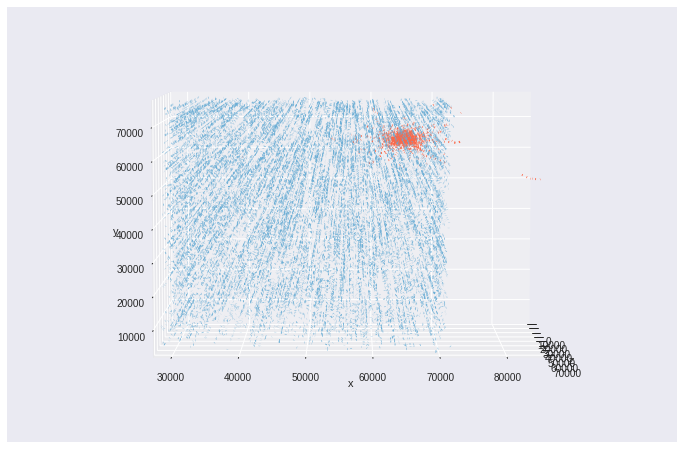

In [15]:
plot_3D_shower(train_np)

In [16]:
%%cython  --compile-args=-fopenmp --link-args=-fopenmp -a -f --compile-args=-DCYTHON_TRACE=1 
cimport cython
import numpy as np
cimport numpy as np
from cython.parallel import prange
from libc.math cimport sqrt, fabs, log, abs

@cython.linetrace(True)
@cython.binding(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
cdef double rms_integral_root(double[:] row_1, double[:] row_2) nogil:
    cdef double dx, dy, dtx, dty, dz
    cdef int N = 100
    cdef int i
    cdef double result = 0
    dz = row_2[8] - row_1[3]
    dx = row_1[1] - (row_2[1] - row_2[4] * dz)
    dy = row_1[2] - (row_2[2] - row_2[5] * dz)
    dtx = row_1[4] - row_2[4]
    dty = row_1[5] - row_2[5]
    for i in range(1, N + 1):
        result += sqrt((dtx * dz / i + dx)**2 + (dty * dz / i + dy)**2) * dz / N
    return result
from scipy.spatial import cKDTree
@cython.linetrace(True)
@cython.binding(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def calc_stat(np.ndarray[double, ndim=2] train_np, double bt_z, double slope):
    cdef double[:, :] curr_layer = train_np[(train_np[:, 3] == bt_z),:] #chosen layer
    cdef double[:, :] next_layers = train_np[(train_np[:, 3] == (bt_z + 1293.)), :] #following layers
    sig_loc = list()
    idx_loc = list()
    idx_neighbour = list()
    f1, f2, f3, f4, f5, f6, f7 = list(), list(), list(), list(), list(), list(), list()
    cdef int N = curr_layer.shape[0]
    cdef int D = curr_layer.shape[1]
    cdef int K = next_layers.shape[0]
    cdef double r_0
    cdef double r_1 
    cdef int r_arg_0
    cdef int r_arg_1
    cdef int i, j, j_tmp
    cdef double diff, r, cmp_x, cmp_y, cmp_x_middle, cmp_y_middle, diff_abs, high_x, low_x, high_y, low_y
    diff = 1293.
    diff_abs = 1293. * 0.15
    if K == 0:
        return idx_loc, sig_loc, f1, f2, f3, f4, f5, f6, f7, idx_neighbour
    kdtree = cKDTree(next_layers[:, 1:3])
    points_of_interest = list()
    for i in range(N):
        points_of_interest.append([curr_layer[i, 1] + diff * curr_layer[i, 4], curr_layer[i, 2] + diff * curr_layer[i, 5]])
    #associated_points_list = kdtree.query_ball_point(points_of_interest, diff * 0.5)
    K = 50
    associated_points_list = kdtree.query(points_of_interest, k=K)[1]
    cdef long[:, :] associated_points = np.array(associated_points_list)
    #for i in range(N):
    for i in prange(N, nogil=True):
        #print (i)
        r_arg_0 = 0
        r_arg_1 = 0
        r_0 = 1000000000000000.
        r_1 = 1000000000000000.
        cmp_x_middle = diff * curr_layer[i, 4]
        high_x = cmp_x_middle + diff_abs
        low_x = cmp_x_middle - diff_abs
        cmp_y_middle = diff * curr_layer[i, 5]
        high_y = cmp_y_middle + diff_abs
        low_y = cmp_y_middle - diff_abs
        #K = len(associated_points_list[i])
        for j_tmp in range(K):
            j = associated_points[i][j_tmp]
            cmp_x = next_layers[j, 1] - curr_layer[i, 1]
            cmp_y = next_layers[j, 2] - curr_layer[i, 2]
            if cmp_x <= high_x:
                if cmp_x >= low_x:
                    if cmp_y <= high_y:
                        if cmp_y >= low_y:
                            r = rms_integral_root(curr_layer[i], next_layers[j])
                            if r < r_0:
                                r_1 = r_0
                                r_arg_1 = r_arg_0
                                r_0 = r
                                r_arg_0 = j
                                continue
                            if r < r_1:
                                r_1 = r
                                r_arg_1 = j
        with gil:
            if r_arg_0 != 0:
                f1.append(r_0)
                f2.append(r_1)
                fl_0 = abs(next_layers[r_arg_0, 4] - curr_layer[i, 4]) + abs(next_layers[r_arg_0, 5] - curr_layer[i, 5])
                fl_1 = abs(next_layers[r_arg_1, 4] - curr_layer[i, 4]) + abs(next_layers[r_arg_1, 5] - curr_layer[i, 5])
                f3.append(fl_0)
                f4.append(fl_1)
                f5.append(curr_layer[i, 9])
                f6.append(next_layers[r_arg_0, 9])
                f7.append(next_layers[r_arg_1, 9])
                idx_loc.append(curr_layer[i, 0])
                sig_loc.append(curr_layer[i, 10])
                idx_neighbour.append(next_layers[r_arg_0, 0])
    return idx_loc, sig_loc, f1, f2, f3, f4, f5, f6, f7, idx_neighbour

ERROR:root:Cell magic `%%cython` not found.


In [10]:
%%time
import numpy as np
num_sig = 0
train_xgb = np.zeros((0, 7))
sig = np.zeros((0))
for idx in idx_len_greater_100:
    train = combine_mc_bg(pmc, pbg, events=[idx], bg_frac=1)
    if num_sig >= 30:
        break
    if sum(train.signal) < 100:
        continue
    else:
        num_sig += 1
        print (idx, sum(train.signal))
    train = train.reset_index(drop=True)
    train_np = numpy.concatenate((numpy.array([train.index.values]).T, train.values), axis=1)
    f1, f2, f3, f4, f5, f6, f7 = list(), list(), list(), list(), list(), list(), list()
    sig_tmp = list()
    idx = list()
    idx_neighbour = list()
    results = [calc_stat(train_np, bt_z, 0.15) for bt_z in BT_Z_unique]
    for result in results:
        idx += result[0]
        sig_tmp += result[1]
        f1 += result[2]
        f2 += result[3]
        f3 += result[4]
        f4 += result[5]
        f5 += result[6]
        f6 += result[7]
        f7 += result[8]
        idx_neighbour += result[9]
    #train for xgboost
    train_xgb_tmp = np.dstack((f1, f2, f3, f4, f5, f6, f7)).reshape((-1, 7))
    train_xgb = np.concatenate((train_xgb, train_xgb_tmp))
    sig_tmp = np.array(sig_tmp)
    sig = np.concatenate((sig, sig_tmp))

4586 3542
2573 313
4808 148
7056 505
3657 117
9788 100
9078 595
8618 394
6045 280
6945 156
4924 548
4033 554
7985 124
3231 1478
6342 961
5972 141
5435 879
9616 286
5477 129
2637 665
4110 529
5378 1253
4729 348
6421 394
9843 693
9112 454
9212 421
2027 115
5791 1010
2259 704
CPU times: user 5h 44min 52s, sys: 25min 35s, total: 6h 10min 28s
Wall time: 58min 56s


In [11]:
print ("Number of basetracks:", len(sig))
print ("Number of signal basetracks:", sum(sig))

Number of basetracks: 70988632
Number of signal basetracks: 17275.0


In [12]:
import lightgbm as lgb
from sklearn.cross_validation import train_test_split

In [13]:
%%time
params = {'max_depth' : 3,
          'n_estimators' : 1000,
            'scale_pos_weight' : 1000}

clf = lgb.LGBMClassifier(max_bin=63, learning_rate=0.065, **params)
clf.fit(train_xgb, sig);

CPU times: user 7h 54min 40s, sys: 16min 7s, total: 8h 10min 48s
Wall time: 18min 27s


## Second part

Prediction on test examples and applying Conditional random field on selected subset of data.

In [14]:
%%time
shower_num = 0
test_xgb = np.zeros((0, 7))
sig = np.zeros((0))
indices = np.zeros((0))
shower_id = np.zeros((0))
train_np_full  = np.zeros((0, 18))
count = 0
energies = []
for idx in idx_len_greater_100[2000:]:
    if count > 50: break
    energies.append(float(pmc.loc[pmc.Event_id == idx].ele_P))
    count += 1
    train = combine_mc_bg(pmc, pbg, events=[idx], bg_frac=1)
    train = train.reset_index(drop=True)
    train_np = numpy.concatenate((numpy.array([train.index.values]).T, train.values), axis=1)
    train_np = numpy.concatenate((train_np, np.full(fill_value=shower_num, shape=(len(train_np), 1), dtype=int)), axis=1)
    train_np_full = np.concatenate((train_np_full, train_np))
    sig_tmp = list()
    idx_tmp = list()
    f1, f2, f3, f4, f5, f6, f7 = list(), list(), list(), list(), list(), list(), list()
    results = [calc_stat(train_np, bt_z, 0.15) for bt_z in BT_Z_unique]
    for result in results:
        idx_tmp += result[0]
        sig_tmp += result[1]
        f1 += result[2]
        f2 += result[3]
        f3 += result[4]
        f4 += result[5]
        f5 += result[6]
        f6 += result[7]
        f7 += result[8]
    #train for xgboost
    test_xgb_tmp = np.dstack((f1, f2, f3, f4, f5, f6, f7)).reshape((-1, 7))
    test_xgb = np.concatenate((test_xgb, test_xgb_tmp))
    sig_tmp = np.array(sig_tmp)
    sig = np.concatenate((sig, sig_tmp))
    shower_id_tmp = np.full(fill_value=shower_num, shape=len(sig_tmp), dtype='int32')
    shower_id  = np.concatenate((shower_id, shower_id_tmp))
    shower_num += 1
    idx_tmp = np.array(idx_tmp).astype(int) + len(train_np_full) - len(train_np)
    print (len(idx_tmp))
    indices = np.concatenate((indices, idx_tmp))
indices = indices.astype(int)

2367059
2368808
2367981
2365999
2366329
2367426
2366197
2366699
2366618
2365103
2365767
2365752
2366248
2366511
2366339
2366698
2366640
2367086
2366824
2365779
2366713
2369552
2365376
2367412
2365734
2364928
2366453
2365726
2367729
2367460
2367644
2365932
2366230
2367063
2366852
2366933
2366925
2364838
2365919
2366561
2365663
2367123
2366675
2367579
2366289
2367237
2366090
2366254
2366687
2366052
2364242
CPU times: user 9h 54min 14s, sys: 44min 23s, total: 10h 38min 37s
Wall time: 1h 48min 49s


In [15]:
indices = indices.astype(int)

In [16]:
pred = clf.predict_proba(test_xgb)[:,1]

In [17]:
threshold = 0.99
train_np = train_np_full[indices[pred >= threshold]]
shower_id_selected = shower_id[pred >= threshold]

print ('# basetrack', len(train_np))
print ('# signal basetrack', sum(train_np[:,10]))

# basetrack 21283
# signal basetrack 9701.0


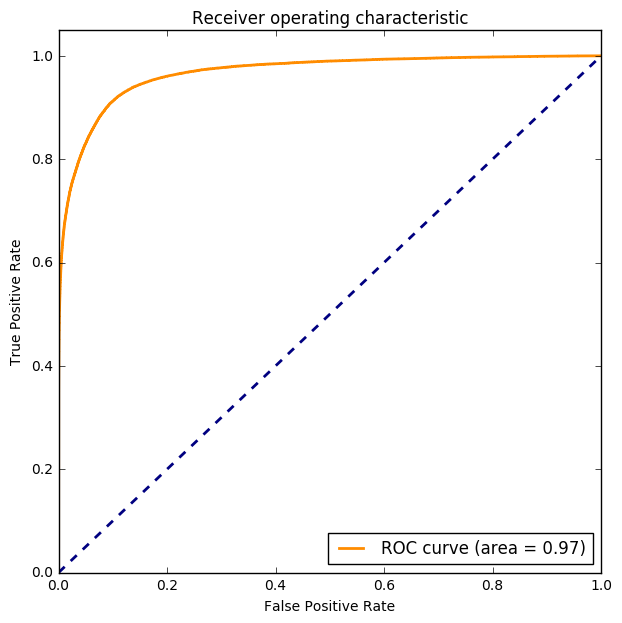

In [18]:
from sklearn.metrics import accuracy_score, auc, recall_score, roc_curve, precision_score, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, confusion_matrix

fpr, tpr, _ = roc_curve(sig, pred, drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

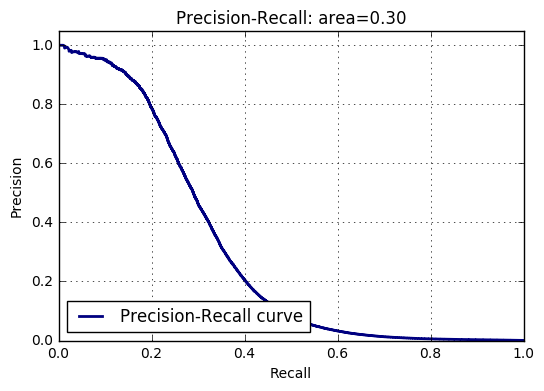

In [19]:
precision, recall, _ = precision_recall_curve(sig, pred)
average_precision = average_precision_score(sig, pred)
plt.clf()
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: area={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [20]:
l = np.unique(train_np[:,3])

In [21]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def plot_density(data): #2d-data
    m1, m2 = data[0], data[1]
    xmin, xmax = min(m1), max(m1)
    ymin, ymax = min(m2), max(m2)
    
    x, y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([x.ravel(), y.ravel()])
    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, x.shape)

    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.imshow(np.rot90(f), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
    plt.scatter(m1, m2)
    cset = plt.contour(x,y,f)
    plt.clabel(cset, inline=1, fontsize=10)
    plt.colorbar()
    plt.show()

In [22]:
def plot_3D_shower(train_np):
    x_min = train_np[:,3].min()
    x_max = train_np[:,3].max()
    y_min = train_np[:,1].min()
    y_max = train_np[:,1].max()
    z_min = train_np[:,2].min()
    z_max = train_np[:,2].max()
    d0 = train_np[:,[3,1,2]][train_np[:, 10] == 0]
    d1 = train_np[:,[8,6,7]][train_np[:, 10] == 0]
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0, d1)), colors=C, alpha=0.5, lw=2)
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=5)
    d0 = train_np[:,[3,1,2]][train_np[:, 10] == 1]
    d1 = train_np[:,[8,6,7]][train_np[:, 10] == 1]
    C = plt.cm.Blues(0.5)#plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(list(zip(d0, d1)), colors=C, alpha=0.5, lw=2)

    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    plt.show()

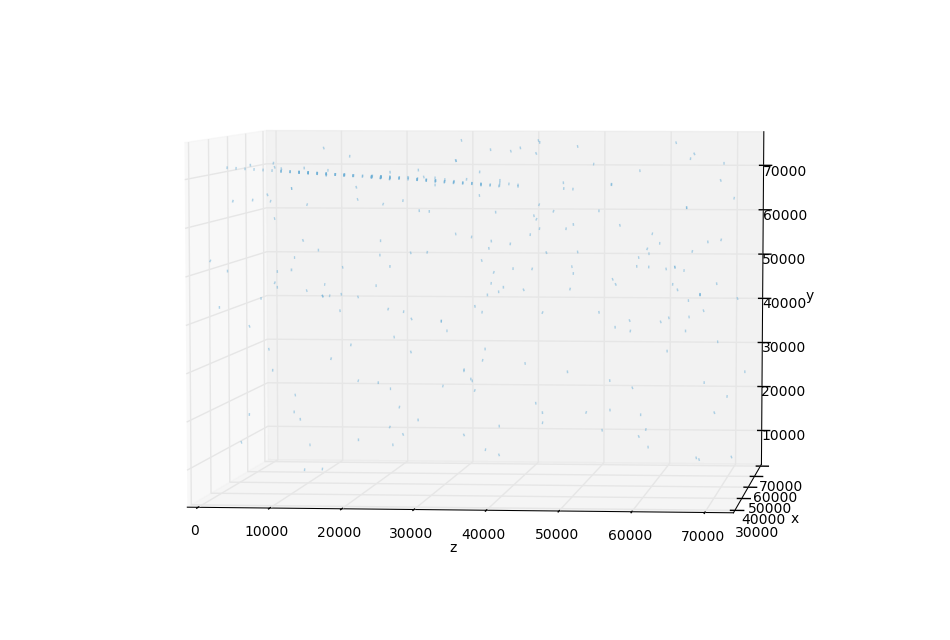

In [25]:
threshold = 0.99
shower = 4
plt.figure(figsize=(15, 15))
train_np = train_np_full[indices[pred >= threshold]]
shower_id_selected = shower_id[pred >= threshold]
train_np = train_np[shower_id_selected == shower]
train_np[:,0] = np.arange(len(train_np))
plot_3D_shower(train_np)

In [26]:
def rms_integral_root(row_1, row_2):
    N = 100
    result = 0
    dz = row_2[8] - row_1[3]
    dx = row_1[1] - (row_2[1] - row_2[4] * dz)
    dy = row_1[2] - (row_2[2] - row_2[5] * dz)
    dtx = row_1[4] - row_2[4]
    dty = row_1[5] - row_2[5]
    i = np.arange(1, N + 1)
    result = np.sum(np.sqrt((dtx * dz / i + dx)**2 + (dty * dz / i + dy)**2) * dz / N)
    return result

In [1]:
def CRF_model(train_np_full, pred, threshold, indices, shower_id, shower):
    eps = 1e-6
    
    all_indices = np.arange(len(indices))
    log_pred = np.log(pred[pred >= threshold])
    log_pred -= np.percentile(np.log(pred[pred >= threshold]), q=35)
    train_np = train_np_full[indices[pred >= threshold]]
    full_number_of_signal = sum(train_np_full[train_np_full[:, 17] == shower][:, 10])
    shower_id_selected = shower_id[pred >= threshold]
    all_indices_threshold = indices[pred >= threshold]
    all_indices_threshold = all_indices_threshold[shower_id_selected == shower]
    train_np = train_np[shower_id_selected == shower]
    log_pred = log_pred[shower_id_selected == shower]
    train_np[:,0] = np.arange(len(train_np))
    
    
    import maxflow
    g = maxflow.GraphFloat()
    g.add_nodes(len(train_np))
    count_number_of_edges_per_node = np.zeros(len(train_np))
    x_coord = list()
    y_coord = list()
    z_coord = list()
    from IPython.display import clear_output
    slope = 0.1
    num = 0
    N = 0
    for bt_z in BT_Z_unique:
        curr_train = train_np[(train_np[:,3] < bt_z + 1293.) & (train_np[:,3] >= bt_z),:] #выбранный слой
        selection = (train_np[:,3] <= bt_z + 3*1293.) & (train_np[:,3] > bt_z) #следующие за ним два слоя
        curr_train_2 = train_np[selection, :]
        for row in (curr_train):
            diff = curr_train_2[:,3] - row[3]
            tmp = curr_train_2[
                ( (curr_train_2[:,1] - row[1]) <= (diff * (row[4] + slope) ) ) &
                ( (curr_train_2[:,1] - row[1]) >= (diff * (row[4] - slope) ) ) &
                ( (curr_train_2[:,2] - row[2]) <= (diff * (row[5] + slope) ) ) &
                ( (curr_train_2[:,2] - row[2]) >= (diff * (row[5] - slope) ) ) ,:] #отбираем те, что в конусе
            num += len(tmp)
            N += 1
            for row_target in tmp:
                r = rms_integral_root(row, row_target)
                if int(row_target[0]) == int(row[0]):
                    continue
                if r > 500000:
                    continue
                fl = 100 * 500000 / r
                g.add_edge(int(row[0]), int(row_target[0]), fl, fl)
                count_number_of_edges_per_node[int(row[0])] += 1
                count_number_of_edges_per_node[int(row_target[0])] += 0.5
                
    i = 0
    for potential in log_pred:
        g.add_tedge(i, -potential * np.log(1 + count_number_of_edges_per_node[i]), -eps)
        i += 1
    #return train_np[:,10], count_number_of_edges_per_node
    g.maxflow()
    predictions = list()
    for i in range(len(train_np)):
        predictions.append(g.get_segment(i))
    predictions = np.array(predictions)
    all_indices_threshold = all_indices_threshold[predictions == 1]
    return full_number_of_signal, train_np[:,10], predictions, (log_pred > np.log(threshold)), all_indices_threshold

In [2]:
%%time

full_number_of_signal, true_labels, crf_predictions, xgb_predictions, all_indices_threshold = CRF_model(train_np_full, pred, 0.95, indices, shower_id, 0)

signal_noise_sum_crf = sum(crf_predictions * true_labels)
signal_noise_sum_xgb = sum(xgb_predictions * true_labels)
noise_len_crf = sum(crf_predictions)
noise_len_xgb = sum(xgb_predictions)
full_number_of_signal_sum = full_number_of_signal
print ("bkg/signal raito crf", (noise_len_crf - signal_noise_sum_crf) / signal_noise_sum_crf)
print ("efficiency crf", signal_noise_sum_crf / full_number_of_signal_sum)
print ("precision", signal_noise_sum_crf / noise_len_crf)
print ("recall", signal_noise_sum_crf / ( full_number_of_signal_sum ))
print ()

NameError: name 'train_np_full' is not defined

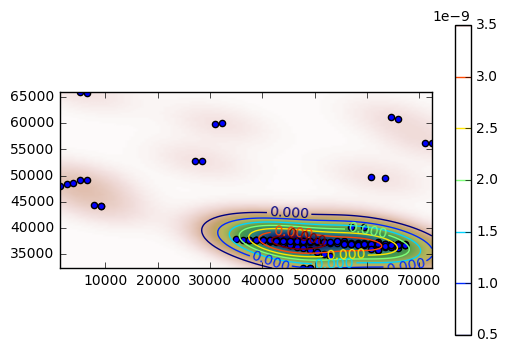

In [49]:
tmp = train_np_full[all_indices_threshold]
plot_density([tmp[:, 3], tmp[:, 1]])

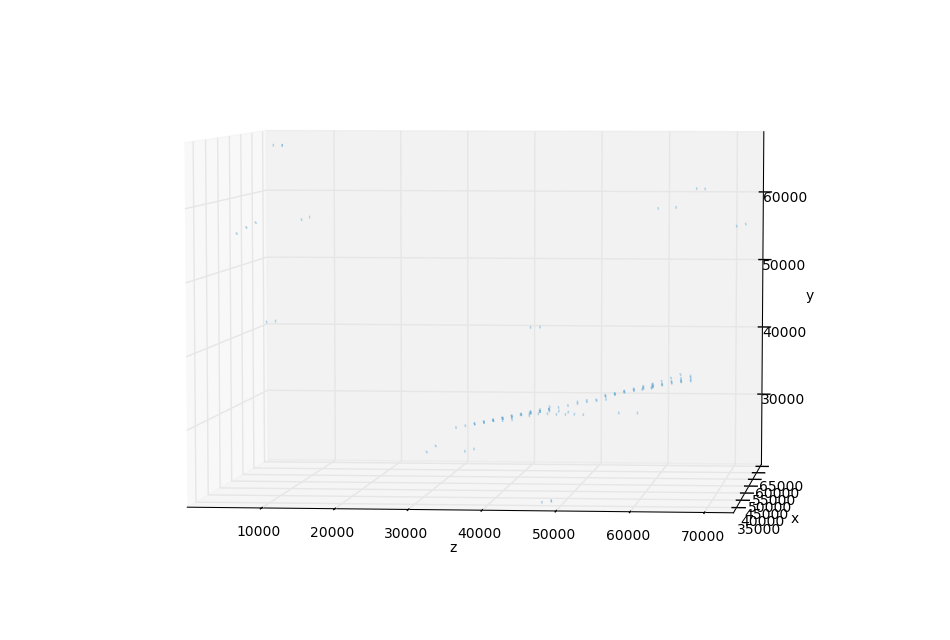

In [50]:
plot_3D_shower(tmp)

In [77]:
thresholds = 1 - np.logspace(-3, -0.5, 30)
signal_noise_sum_crf_list = list()
signal_noise_sum_xgb_list = list()
noise_len_crf_list = list()
noise_len_xgb_list = list()
full_number_of_signal_sum_list = list()
precision = list()
recall = list()

for threshold in thresholds:
    print (threshold)
    signal_noise_sum_crf = 0
    signal_noise_sum_xgb = 0
    noise_len_crf = 0
    noise_len_xgb = 0
    full_number_of_signal_sum = 0
    for shower in np.unique(shower_id_selected):
        print (shower, end=' ')
        try:
            full_number_of_signal, true_labels, crf_predictions, xgb_predictions, all_indices_threshold = CRF_model(train_np_full, pred, threshold, indices, shower_id, shower)
        except:
            continue
        signal_noise_sum_crf += sum(crf_predictions * true_labels)
        signal_noise_sum_xgb += sum(xgb_predictions * true_labels)
        noise_len_crf += sum(crf_predictions)
        noise_len_xgb += sum(xgb_predictions)
        full_number_of_signal_sum += full_number_of_signal
    signal_noise_sum_crf_list.append(signal_noise_sum_crf)
    signal_noise_sum_xgb_list.append(signal_noise_sum_xgb)
    noise_len_crf_list.append(noise_len_crf)
    noise_len_xgb_list.append(noise_len_xgb)
    full_number_of_signal_sum_list.append(full_number_of_signal_sum)
    precision.append(signal_noise_sum_crf / noise_len_crf)
    recall.append(signal_noise_sum_crf / full_number_of_signal_sum )
    print ("bkg/signal raito crf", (noise_len_crf - signal_noise_sum_crf) / signal_noise_sum_crf)
    print ("efficiency crf", signal_noise_sum_crf / full_number_of_signal_sum)
    print ("precision", precision[-1])
    print ("recall", recall[-1])
    print ()
signal_noise_sum_crf_list = np.array(signal_noise_sum_crf_list)
signal_noise_sum_xgb_list = np.array(signal_noise_sum_xgb_list)
noise_len_crf_list = np.array(noise_len_crf_list)
noise_len_xgb_list = np.array(noise_len_xgb_list)
full_number_of_signal_sum_list = np.array(full_number_of_signal_sum_list)

0.999
0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 bkg/signal raito crf 0.00125849484017
efficiency crf 0.119137579465
precision 0.998743086978
recall 0.119137579465

0.99878042954
0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 bkg/signal raito crf 0.00115207373272
efficiency crf 0.130142737196
precision 0.998849252014
recall 0.130142737196

0.998512647893
0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.

In [53]:
threshold = 0.99
shower_lengthes = list()
for shower in np.unique(shower_id_selected):
    print (shower, end=' ')
    full_number_of_signal, true_labels, crf_predictions, xgb_predictions, all_indices_threshold = CRF_model(train_np_full, pred, threshold, indices, shower_id, shower)
    shower_lengthes.append(sum(crf_predictions))

0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 

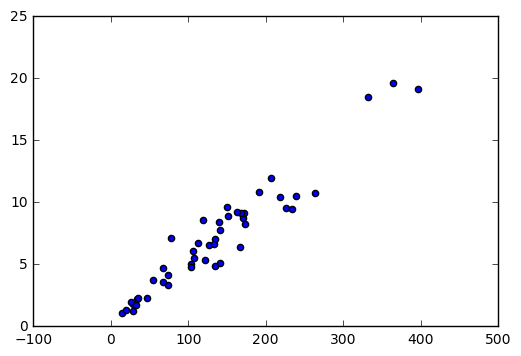

In [78]:
plt.scatter(shower_lengthes[energies<20], energies[energies<20])

In [79]:
slope, intercept, r_value, p_value, std_err = stats.linregress(shower_lengthes[energies<20], energies[energies<20])

In [80]:
std_err

0.0020666471702741212

In [83]:
1 - np.logspace(-3, -0.5, 30)

array([ 0.999     ,  0.99878043,  0.99851265,  0.99818607,  0.99778778,
        0.99730205,  0.99670966,  0.99598719,  0.9951061 ,  0.99403154,
        0.99272105,  0.9911228 ,  0.98917363,  0.98679648,  0.98389738,
        0.98036172,  0.97604973,  0.97079096,  0.96437752,  0.95655588,
        0.94701683,  0.93538329,  0.92119537,  0.9038922 ,  0.88278977,
        0.85705387,  0.82566712,  0.78738877,  0.74070562,  0.68377223])

In [84]:
np.trapz(x=recall, y=precision)

0.36481629264099619

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


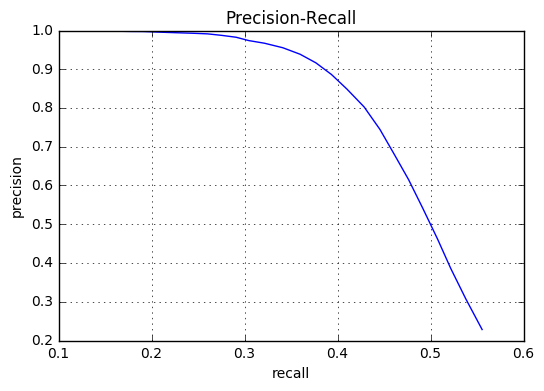

In [85]:
plt.plot(recall, precision)
plt.grid()
plt.title('Precision-Recall')
plt.legend(loc="lower left")
plt.xlabel('recall')
plt.ylabel('precision')

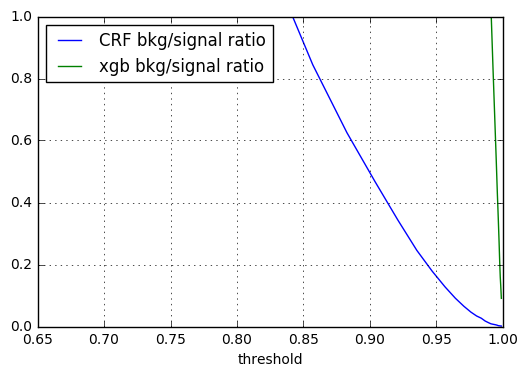

In [86]:
plt.clf()
plt.ylim(0, 1)
plt.plot(thresholds, (noise_len_crf_list - signal_noise_sum_crf_list) / signal_noise_sum_crf_list, label='CRF bkg/signal ratio')
plt.plot(thresholds, (noise_len_xgb_list - signal_noise_sum_xgb_list) / signal_noise_sum_xgb_list, label='xgb bkg/signal ratio')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('threshold')
plt.grid()
plt.legend(loc='upper left')

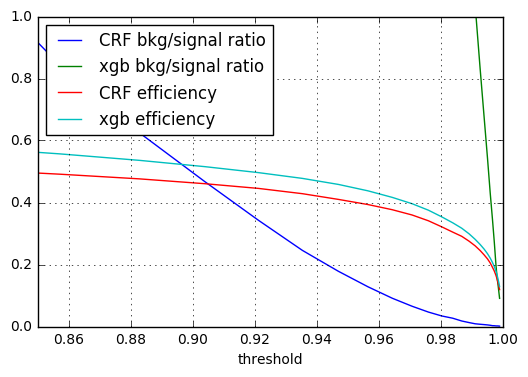

In [89]:
plt.ylim(0, 1)
plt.xlim(0.85, 1)
plt.plot(thresholds, (noise_len_crf_list - signal_noise_sum_crf_list) / signal_noise_sum_crf_list, label='CRF bkg/signal ratio')
plt.plot(thresholds, (noise_len_xgb_list - signal_noise_sum_xgb_list) / signal_noise_sum_xgb_list, label='xgb bkg/signal ratio')
#plt.xscale('log')
plt.plot(thresholds, signal_noise_sum_crf_list / full_number_of_signal_sum_list, label='CRF efficiency')
plt.plot(thresholds, signal_noise_sum_xgb_list / full_number_of_signal_sum_list, label='xgb efficiency')
plt.xlabel('threshold')
plt.grid()
plt.legend(loc='upper left')

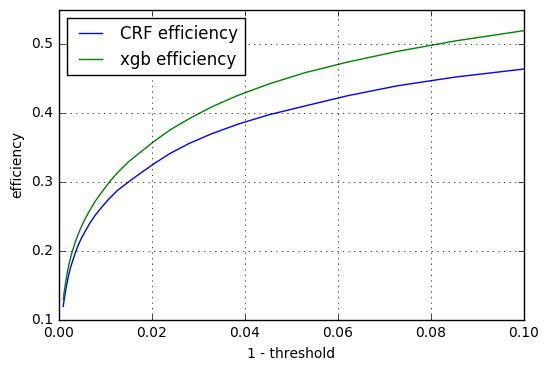

In [62]:
plt.clf()
plt.plot(1-thresholds, signal_noise_sum_crf_list / full_number_of_signal_sum_list, label='CRF efficiency')
plt.plot(1-thresholds, signal_noise_sum_xgb_list / full_number_of_signal_sum_list, label='xgb efficiency')
#plt.xscale('log')
plt.ylabel('efficiency')
plt.xlabel('1 - threshold')
plt.grid()
plt.legend(loc='upper left')

In [ ]:
%%time
threshold = 0.98
shower_num = 0
test_xgb = np.zeros((0, 7))
sig = np.zeros((0))
indices = np.zeros((0))
shower_id = np.zeros((0))
train_np_full  = np.zeros((0, 18))
count = 0
energies = []
shower_lengthes = list()

for idx in idx_len_greater_100[2000:]:
    if count > 400: break
    print (count, end = ' ')
    energies.append(float(pmc.loc[pmc.Event_id == idx].ele_P))
    count += 1
    shower_num += 1
    train = combine_mc_bg(pmc, pbg, events=[idx], bg_frac=1)
    train = train.reset_index(drop=True)
    train_np = numpy.concatenate((numpy.array([train.index.values]).T, train.values), axis=1)
    train_np_full = numpy.concatenate((train_np, np.full(fill_value=shower_num, shape=(len(train_np), 1), dtype=int)), axis=1)
    sig_tmp = list()
    idx_tmp = list()
    f1, f2, f3, f4, f5, f6, f7 = list(), list(), list(), list(), list(), list(), list()
    results = [calc_stat(train_np, bt_z, 0.15) for bt_z in BT_Z_unique]
    for result in results:
        idx_tmp += result[0]
        sig_tmp += result[1]
        f1 += result[2]
        f2 += result[3]
        f3 += result[4]
        f4 += result[5]
        f5 += result[6]
        f6 += result[7]
        f7 += result[8]
    #train for xgboost
    test_xgb = np.dstack((f1, f2, f3, f4, f5, f6, f7)).reshape((-1, 7))
    pred = clf.predict_proba(test_xgb)[:,1]
    sig = np.array(sig_tmp)
    indices = np.array(idx_tmp).astype(int)
    shower_id_tmp = np.full(fill_value=shower_num, shape=len(sig_tmp), dtype='int32')
    shower_id  = shower_id_tmp
    idx_tmp = np.array(idx_tmp).astype(int) + len(train_np_full) - len(train_np)
    full_number_of_signal, true_labels, crf_predictions, xgb_predictions, all_indices_threshold = CRF_model(train_np_full, pred, threshold, indices, shower_id, shower_num)
    shower_lengthes.append(sum(crf_predictions))
    if count > 3:
        shower_lengthes_np = np.array(shower_lengthes)
        energies_np = np.array(energies)
        slope, intercept, r_value, p_value, std_err = stats.linregress(shower_lengthes_np[energies_np<20], 
                                                                       energies_np[energies_np<20])
        print (std_err, r_value)
        resolutions = list()
        for length, energy in zip(shower_lengthes_np[energies_np<20], energies_np[energies_np<20]):
            resolutions += [(abs(energy - (length * slope + intercept)) / energy)]
        print (np.mean(resolutions), np.std(resolutions))

0 1 2 3 

/home/ubuntu/anaconda3/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan 1.0
0.0 0.0
4 0.00301949615693 0.993443635343
0.0175691785064 0.00815578058629
5 0.00466025952524 0.985960237484
0.059143119306 0.0320061809954
6 0.00436525702454 0.981291546888
0.0587346772347 0.0332919592238
7 0.00436525702454 0.981291546888
0.0587346772347 0.0332919592238
8 0.00389185407369 0.981567810184
0.0691337739956 0.041832210951
9 0.0122868066904 0.759132647245
0.172139847319 0.115088124879
10 0.0109167887465 0.771675700044
0.15557743958 0.118176305874
11 0.00969749932308 0.798063380032
0.142770873869 0.113828902322
12 0.00919892364039 0.800848794164
0.142894454953 0.11094376283
13 0.00742042059153 0.858758824224
0.1391284032 0.116838595385
14 0.00384743804397 0.96922434658
0.135676412451 0.106109330382
15 0.00360789415711 0.970113984009
0.125703877872 0.107202794045
16 0.00438888698108 0.938786932389
0.13266328688 0.111302022268
17 0.00404402748639 0.943712284852
0.128172931722 0.108914867293
18 0.00388930136997 0.944141005713
0.124953984372 0.107251424975
19 0.003622990

In [127]:
shower_lengthes = np.array(shower_lengthes)
energies = np.array(energies)

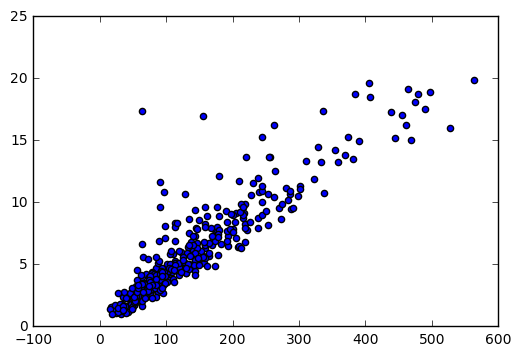

In [128]:
plt.scatter(shower_lengthes[energies<=20], energies[energies<=20])

In [166]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [182]:
lr=LogisticRegression().fit(np.array([shower_lengthes[energies < 20]]).T, energies[energies < 20])

ValueError: Unknown label type: 'continuous'

In [180]:
predictions=lr.predict(np.array([shower_lengthes]).T)

In [181]:
for pr, energy in zip(predictions[energies<20], energies[energies < 20]):
    resolutions += [(energy - pr) / energy]
print (np.mean(resolutions), np.std(resolutions)) 

-0.0487807027428 0.269238858859


In [163]:
slope, intercept, r_value, p_value, std_err = stats.linregress(shower_lengthes[energies<=7], 
                                                                energies[energies<=7])
print (std_err, r_value)
resolutions = list()
for length, energy in zip(shower_lengthes_np[energies_np<=20], energies_np[energies_np<=20]):
    resolutions += [(energy - (length * slope + intercept)) / energy]
print (np.mean(resolutions), np.std(resolutions))

0.00112599537023 0.87889030704
0.0122900286489 0.26245222924


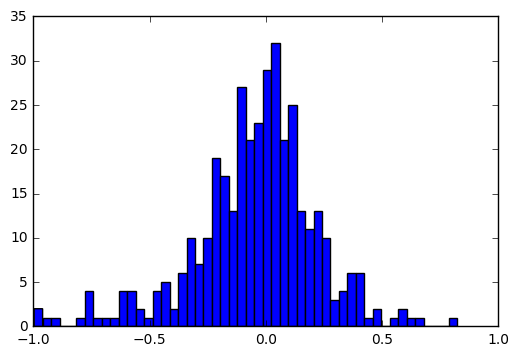

In [162]:
plt.hist(resolutions, bins=50);

In [158]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
mean,std=norm.fit(resolutions)

In [159]:
mean

0.036939433129926369

In [160]:
std

0.25416355130981738

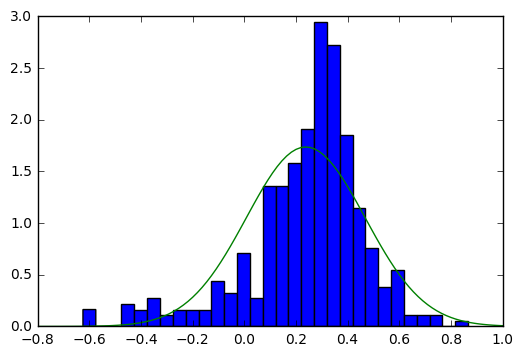

In [153]:
plt.hist(resolutions, bins=30, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()